In [3]:
import numpy as np
import pickle

import matplotlib.pyplot as plt

/Users/danielgilman/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/danielgilman/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


### Create a mock simulation

You can use the function compile_output in the utilities folder of quadmodel to compile all of the individual core outputs into a single class called FullSimultionContainer. Here, we'll assume this step is done already, and create a FullSimulationContainer class by hand. Each lens should correpond to one FullSimulationContainer class

In [65]:
from quadmodel.inference.util import FullSimulationContainer

# dummy model output be a Gaussian

true_x_1 = 0.0
true_x_2 = 1.0
true_x_3 = 0.1
true_x_4 = 0.15

i_max_lens = 5

for i in range(0, i_max_lens):
    
    x1 = np.random.normal(true_x_1, 0.1, 1000)
    x2 = np.random.normal(true_x_2, 0.1, 1000)
    x3 = np.random.normal(true_x_3, 0.05, 1000)
    x4 = np.random.normal(true_x_4, 0.05, 1000)
    
    summary_stat = np.array([0.01]*len(x1))
    parameters = np.empty((1000, 5))
    parameters[:, 0], parameters[:,1], parameters[:,2], parameters[:,3], parameters[:,4] = x1, x2, x3, x4, summary_stat

    individual_simulations = None 
    magnifications = None
    container = FullSimulationContainer(individual_simulations, parameters, magnifications)
    

    f = open('./example_simulation_output/sim_'+str(i+1), 'wb')
    pickle.dump(container, f)
    f.close()

### Now load the simulation containers, and use the DensitySamples class to store the output

To run this cell, download the package trikde https://github.com/dangilman/trikde

In [68]:
from trikde.pdfs import IndepdendentLikelihoods, DensitySamples

probability_density_list = []

nbins = 10 # number of bins for the N-dimensional histograms
use_kde = False # when multiplying several likelihoods, usually you should turn on the KDE 

keep_inds_params = [0, 1, 3] # keep x1, x2, x4, ignore x2
param_names = ['x1', 'x2', 'x4']
param_ranges = [[-0.5, 0.5], [0.5, 1.5], [0.0, 0.3]]
single_likelihoods = []

for i in range(0, 3):
    
    f = open('./example_simulation_output/sim_'+str(i+1), 'rb')
    simulation = pickle.load(f)
    f.close()
    
    # you can ignore nuisance parameters  by selecting only certain parameters 
    # (note that index -1 is always the summary statistic)
    params = simulation.parameters[:, keep_inds_params]
    # you can make an additional (option) cut on the summary statistics post-processing 
    summary_statistic = simulation.parameters[:, -1]
    summary_cut = 0.05
    keep_inds_summary = np.where(summary_statistic < summary_cut)[0]
    params = params[keep_inds_summary, :]
    weights = None
    density = DensitySamples(params, param_names, weights, param_ranges, nbins=nbins, use_kde=use_kde)
    
    single_pdf = IndepdendentLikelihoods([density])
    probability_density_list.append(density)
    
    single_likelihoods.append(single_pdf)
    
joint_pdf = IndepdendentLikelihoods(probability_density_list)

### Show the distributions

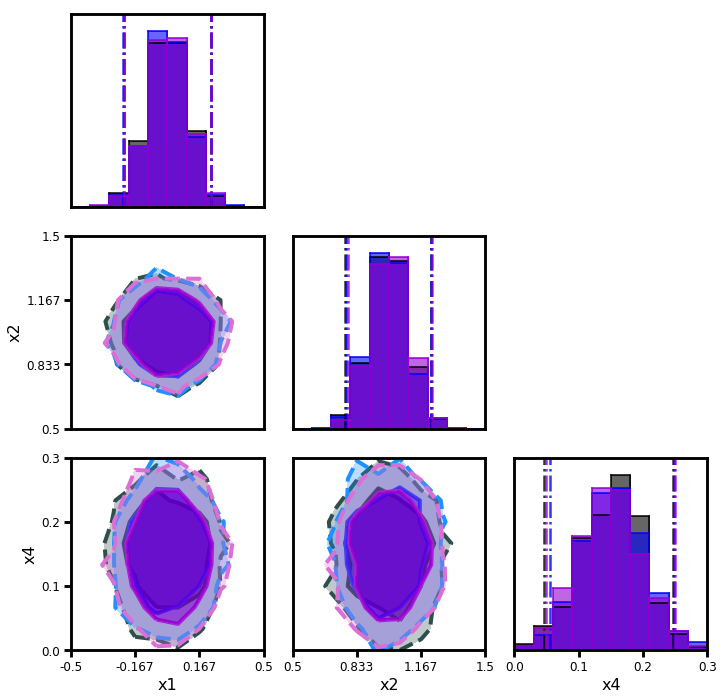

In [70]:
from trikde.triangleplot import TrianglePlot

triplot = TrianglePlot(single_likelihoods)
out = triplot.make_triplot(filled_contours=True)

### Show joint distribution

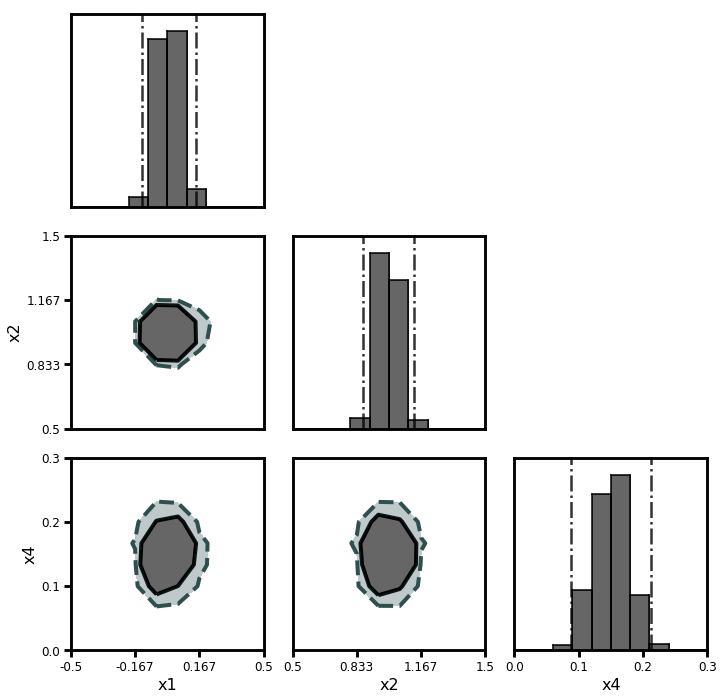

In [71]:
triplot = TrianglePlot([joint_pdf])
out = triplot.make_triplot(filled_contours=True)